# G4LumaCam Tutorial: From Simulation to Empirical Analysis

Tsviki Y. Hirsh

March 8th 2025

Welcome to the G4LumaCam tutorial! This notebook guides you through simulating optical photons from a point source using lumacam, configuring and optimizing a lens system (e.g., Nikkor 58mm f/0.95), simulating neutron sources, and analyzing the data with the lumacam.Analysis module to reconstruct events. This workflow is designed for users working with optical and radiation detection systems.

## Installation

### Prerequisites

It is recommended to install Geant4 through Docker:

```bash
docker pull jeffersonlab/geant4:g4v10.6.2-ubuntu24
```

### Installation Steps

1. Clone the repository:
   ```bash
   git clone https://github.com/TsvikiHirsh/G4LumaCam.git
   ```

2. Navigate to the cloned directory and install:
   ```bash
   cd G4LumaCam
   pip install .
   ```

## Tutorial Structure

1. Optical Photon Simulation: Simulate optical photons from a point source at different scintillator positions using lumacam.Simulate.
2. Lens Optics: Define and optimize a lens system (e.g., Nikkor 58mm f/0.95) to focus optical photons.
3. Neutron Source Simulation: Simulate point and uniform neutron sources for further analysis.
4. Ray Tracing: Trace photons through the optimized lens system.
5. Event Analysis: Use lumacam.Analysis to process and analyze the traced data using `empir`.

Let’s dive in!


In [1]:
import lumacam

# 1. Optical Photon Simulation: Generate Photon Data from a Point Source
## Overview

We use lumacam.Simulate to generate optical photons from a point source within a scintillator. Two configurations are simulated: one at 20 mm (edge facing a 45-degree mirror) and one at 10 mm (middle of a 20 mm thick scintillator). This data will be used to optimize the lens system.
Key Concepts

- Point Source: Emits optical photons with configurable position and direction.
- Scintillator Geometry: A 20 mm thick scintillator with a 45-degree mirror reflecting photons.
- Output: A DataFrame with photon attributes (x, y, z, dx, dy, dz, toa, wavelength).

## Simulation Setup

The image below shows a Geant4 simulation of optical photons from a point source within the scintillator, with a 45-degree mirror and a sensor.


# Geant4 Simulation of Optical Photons
![img](G4LumaCam.png)

Figure 1: Geant4 simulation of optical photon trajectories (purple) from a point source in a scintillator (black), reflected by a 45-degree mirror, directed toward a sensor (red). The green line is the optical axis.

## Example
Simulate optical photons from a point source

In [2]:
# Simulate at 20 mm (edge facing 45-degree mirror)
sim = lumacam.Simulate("archive/focus_20mm")
config = lumacam.Config.opticalphoton_point()
config.position_z = 20

In [3]:
df = sim.run(config)

Simulating:   0%|          | 0/10000 [00:00<?, ?events/s]

In [4]:
# Simulate at 10 mm (middle of 20 mm thick scintillator)
sim = lumacam.Simulate("archive/focus_10mm")
config = lumacam.Config.opticalphoton_point()
config.position_z = 10

In [5]:
df = sim.run(config)

Simulating:   0%|          | 0/10000 [00:00<?, ?events/s]

# 2. Lens Optics: Define and Optimize the Lens System
## Overview

We define a lens system, starting with the Nikkor 58mm f/0.95 lens, and optimize its focus using the simulated photon data. Future versions will support other commercial lenses and the microscope setup of lumacam. The optimization adjusts zfocus (lens movement), zfine (fine focus), and eventually aperture diameter.
Key Concepts

1. Lens Model: Nikkor 58mm f/0.95 with adjustable zfocus and zfine.
2. Ray Tracing: trace_rays propagates photons through the lens.
3. Optimization: zscan for coarse tuning, zscan_optimize for fine-tuning with lmfit.

## Lens System Visualization

The image below depicts the Nikkor 58mm f/0.95 lens system with photon rays passing through multiple lens elements.

Nikkor 58mm f/0.95 Lens System

Figure 2: Diagram of the Nikkor 58mm f/0.95 lens system, showing photon rays (pink) passing through lens elements (red/orange), converging toward a sensor.

## Steps

1. Define Lens: Initialize with the Nikkor lens and simulated data.
2. Adjust Focus: Use refocus to set initial zfocus and zfine.
3. Optimize: Perform coarse and fine tuning.

## Example

Loading simulation data:   0%|          | 0/8 [00:00<?, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


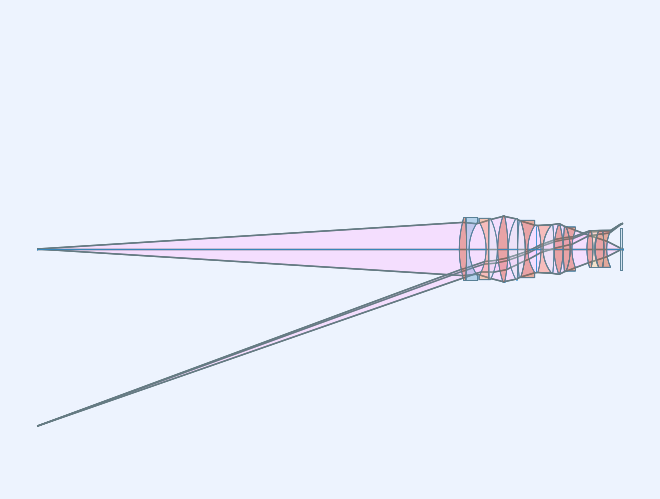

In [8]:
# Code Cell: Define and optimize lens system
import lumacam
import numpy as np

# Initialize lens with Nikkor 58mm f/0.95
lens = lumacam.Lens(archive="archive/focus_20mm", kind='Nikkor_58mm_095')

# Adjust focus (example values)
opm = lens.refocus(zfocus=0, zfine=13.3)
lens.plot(opm)  # Visualize lens system

In [9]:
# Coarse optimization with zscan
s = lens.zscan(zfocus_range=np.arange(-10, 10, 1), zfine_range=13.3)
s

Z-scan (zfocus):   0%|          | 0/20 [00:00<?, ?it/s]

Z-scan completed. Best zfocus: -1.00 with std: 0.018


-10    0.054537
-9     0.049136
-8     0.043828
-7     0.038650
-6     0.033661
-5     0.028956
-4     0.024697
-3     0.021152
-2     0.018728
-1     0.017884
 0     0.018832
 1     0.021332
 2     0.024921
 3     0.029198
 4     0.033904
 5     0.038883
 6     0.044044
 7     0.049329
 8     0.054703
 9     0.060145
dtype: float64

<Axes: >

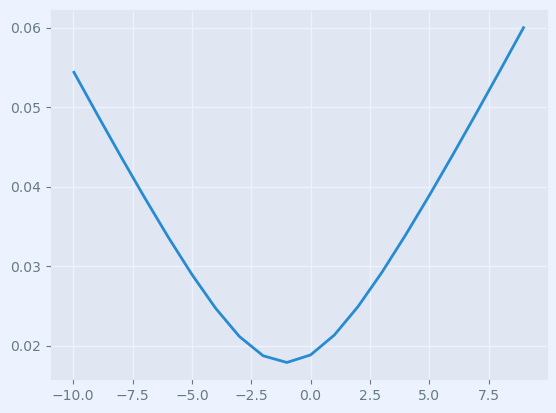

In [10]:
s.plot()

In [14]:
# Fine optimization with zscan_optimize
s = lens.zscan_optimize(initial_zfocus=0, initial_zfine=13.3,optimize_param="both")
s

{'best_zfocus': -1.030000000000001,
 'min_std': np.float64(0.017636176821628224),
 'traced_fraction': 0.9484536082474226,
 'result': <lmfit.minimizer.MinimizerResult at 0x723229930e10>,
 'best_zfine': 13.316154174804687}

# 3. Neutron Source Simulation: Generate Neutron Data
## Overview

We simulate neutron sources to extend the analysis to radiation events. Two configurations are included: a point source of neutrons and a uniform source with varying energies.
## Key Concepts

1. Point Source: A focused neutron source at a specific position.
2. Uniform Source: A distributed source with variable energies.
3. Output: Photon data from neutron interactions, stored in SimPhotons.

## Example


In [15]:
# Point source of neutrons
sim = lumacam.Simulate("archive/point_neutrons")
config = lumacam.Config.neutrons_uniform()
config.num_events = 2000
config.position_z = -1590
config.max_theta = 0
config.halfx = 0.0001
config.halfy = 0.0001
config.csv_batch_size = 100
config.sample_material = "G4_Galactic"
config

Configuration:
  Particle: neutron
  Energy: 10.0 MeV
  Position: (0, 0, -1590) cm
  Direction: (0, 0, 1)
  Shape: Rectangle (0.0001x0.0001 mm)
  Angle: iso (max theta: 0 deg)
  Events: 2000
  Output: sim_data.csv

In [16]:
df = sim.run(config)

Simulating:   0%|          | 0/2000 [00:00<?, ?events/s]

Uniform source with different energies

In [21]:
sim = lumacam.Simulate("archive/neutrons")
config = lumacam.Config.neutrons_uniform_energy()
config.num_events = 2000
config.position_z = -1590
config.energy_min = 1
config.max_theta = 0
config.csv_batch_size = 100
config.sample_material = "G4_Galactic"

In [22]:
df = sim.run(config)

Simulating:   0%|          | 0/2000 [00:00<?, ?events/s]

In [23]:
df

,id,parent_id,neutron_id,x,y,z,dx,dy,dz,toa,wavelength,parentName,px,py,pz,parentEnergy,nx,ny,nz,neutronEnergy
0,2112,3,7,-43.07180,10.2173,40,0.088494,-0.023660,0.995796,519,434.014,proton,-45.62070,10.8986,11.31660,0.006278,-35.52910,5.7446,5.31676,2.01626
1,2478,2,7,-42.61430,13.6683,40,0.058909,-0.015774,0.998139,519,439.451,C12,-44.34090,14.1308,10.74370,0.006278,-35.52910,5.7446,5.31676,2.01626
2,103,3,10,6.59528,-32.5555,40,-0.058633,0.023068,0.998013,349,412.437,C12,7.93795,-33.0840,17.14610,2.908940,7.93792,-33.0827,17.14570,4.54901
3,370,3,12,-39.39940,20.4374,40,0.054505,-0.038766,0.997761,596,400.364,C12,7.93795,-33.0840,17.14610,0.382837,-40.35310,21.1171,22.52830,1.53628
4,903,2,12,-22.64250,16.9356,40,0.097583,0.003585,0.995221,594,404.212,proton,-26.06540,16.8095,5.07988,0.382837,-40.35310,21.1171,22.52830,1.53628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,2961,4,2325,-34.22940,43.5190,40,0.051817,-0.057319,0.997010,266,435.805,proton,-13.72740,39.6412,33.73680,2.039490,-34.74310,44.0257,29.09030,7.92166
3972,2624,4,2325,-34.45120,42.8226,40,0.027108,-0.110704,0.993484,264,479.412,proton,-13.72740,39.6412,33.73680,2.039490,-34.74310,44.0257,29.09030,7.92166
3973,1977,4,2325,-34.46730,43.3783,40,0.026288,-0.061587,0.997755,271,438.959,proton,-13.72740,39.6412,33.73680,2.039490,-34.74310,44.0257,29.09030,7.92166
3974,9049,4,2325,-34.04480,43.3318,40,0.069939,-0.077240,0.994556,265,428.252,proton,-13.72740,39.6412,33.73680,2.039490,-34.74310,44.0257,29.09030,7.92166


# 4. File Structure Explanation
## Overview

The G4LumaCam workflow relies on a structured archive folder to store simulation and analysis data. Users must define this archive directory when initializing simulations or analyses.
## Directory Structure

Below is an example tree structure for the archive/openbeam directory:


    archive/openbeam:
    ├── SimPhotons
    │   ├── macro.mac
    │   ├── sim_data_0.csv
    │   ├── sim_data_1.csv
    │   ├── sim_data_10.csv
    │   ├── sim_data_2.csv
    │   ├── sim_data_3.csv
    │   ├── sim_data_4.csv
    │   ├── sim_data_5.csv
    │   ├── sim_data_6.csv
    │   ├── sim_data_7.csv
    │   ├── sim_data_8.csv
    │   └── sim_data_9.csv
    ├── TracedPhotons
    │   ├── traced_sim_data_0.csv
    │   ├── traced_sim_data_1.csv
    │   ├── traced_sim_data_10.csv
    │   ├── traced_sim_data_2.csv
    │   ├── traced_sim_data_3.csv
    │   ├── traced_sim_data_4.csv
    │   ├── traced_sim_data_5.csv
    │   ├── traced_sim_data_6.csv
    │   ├── traced_sim_data_7.csv
    │   ├── traced_sim_data_8.csv
    │   └── traced_sim_data_9.csv
    ├── PhotonFiles
    │   ├── traced_sim_data_0.empirphot
    │   ├── traced_sim_data_1.empirphot
    │   ├── traced_sim_data_2.empirphot
    │   ├── traced_sim_data_3.empirphot
    │   ├── traced_sim_data_4.empirphot
    │   ├── traced_sim_data_5.empirphot
    │   ├── traced_sim_data_6.empirphot
    │   ├── traced_sim_data_7.empirphot
    │   ├── traced_sim_data_8.empirphot
    │   └── traced_sim_data_9.empirphot
    ├── EventFiles
    │   ├── traced_sim_data_0.empirevent
    │   ├── traced_sim_data_1.empirevent
    │   ├── traced_sim_data_2.empirevent
    │   ├── traced_sim_data_3.empirevent
    │   ├── traced_sim_data_4.empirevent
    │   ├── traced_sim_data_5.empirevent
    │   ├── traced_sim_data_6.empirevent
    │   ├── traced_sim_data_7.empirevent
    │   ├── traced_sim_data_8.empirevent
    │   └── traced_sim_data_9.empirevent
    ├── EventResults
    │   └── batch_0_results.csv
    ├── all_batches_results.csv
    ├── binned.empirevent
    ├── counts.csv
    ├── event_by_event_results.csv
    ├── events_with_shape_parameters.csv
    ├── parameterEvents.json
    └── parameterSettings.json

- SimPhotons: Contains raw simulation data (sim_data_*.csv) and configuration files (macro.mac).
- TracedPhotons: Stores traced photon data after lens processing (traced_sim_data_*.csv).
- EventFiles and PhotonFiles: Hold event and photon data in custom empir formats (.empirevent, .empirphot).
- EventResults: Contains analysis results (e.g., batch_0_results.csv).

# 5. Ray Tracing: Propagate Photons Through the Lens
## Overview

We trace photons through the optimized lens system using the trace_rays method, leveraging the tuned zfocus and zfine values.

In [24]:
lens = lumacam.Lens(archive="archive/neutrons")
opm = lens.refocus(zfocus=10/1.58, zfine=13.3) # focus to the center of the scintillator
data = lens.trace_rays(print_stats=True, opm=opm, chunk_size=500, n_processes=10)

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/8 [00:00<?, ?it/s]

File: sim_data_0.csv - Original events: 3976, Traced events: 3976, Percentage: 100.0%


# 6. Event Analysis: Process and Analyze Data
## Overview

The lumacam.Analysis module processes the traced data to reconstruct neutron or gamma events, offering a streamlined analysis pipeline with customizable parameters.
## Key Concepts

- Reconstruction: Clusters traced photons to estimate event origins.
- Parameters: Adjustable spacing (dSpace_px), time resolution (dTime_s), etc.
- Output: A DataFrame with analyzed event data.

## Example

In [25]:
openbeam = lumacam.Analysis(archive="archive/neutrons").process_data(dSpace_px=1)

Loading traced data:   0%|          | 0/1 [00:00<?, ?it/s]

Loading sim data:   0%|          | 0/1 [00:00<?, ?it/s]

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='stacks'>

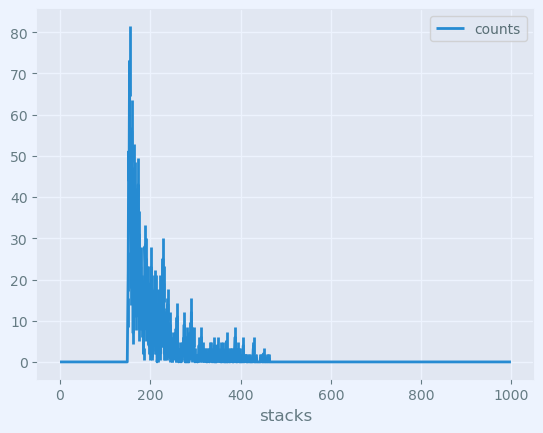

In [27]:
openbeam.plot(x="stacks",y="counts",yerr="err")

# Conclusion

This tutorial covered the G4LumaCam workflow:

- Optical Photon Simulation: Generated photon data from point sources at 20 mm and 10 mm.
- Lens Optics: Defined and optimized the Nikkor 58mm f/0.95 lens system.
- Neutron Source Simulation: Simulated point and uniform neutron sources.
- Ray Tracing: Traced photons through the lens.
- Event Analysis: Processed data with lumacam.Analysis to reconstruct events.

Customize this workflow by adjusting source positions, lens types, or analysis parameters. Refer to the G4LumaCam documentation for advanced features.

Happy experimenting!